# Table of Content
- [Data import](#data-import)
- [Hours with Most Money Spend](#hours-with-most-money-spend)
- [Seasonality](#seasonality)
- [Price Ranges](#price-ranges)
- [Departments](#departments)
- [Loyalty](#loyalty)
- [Region](#region)
- [Age Group and Fam Status](#age-group-and-fam-status)


In [1]:
# imports
from datetime import timedelta
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

import da_helper as da

# project folder
project_folder = Path(r"C:\Users\vynde\Desktop\CareerFoundry Data Analytics\Data Immersion - 4 Python Fundamentals for Data Analysts\Instacart_Basket_Analysis")

# resource folders
original_data_folder = project_folder / "02_Data" / "Original_Data"
prepared_data_folder = project_folder / "02_Data" / "Prepared_Data"
plot_folder = project_folder / "04_Analysis" / "Visualizations"

# input files
final_data_file = prepared_data_folder / "final_data.pkl"
# output files
# None

## Data import [#](#table-of-content)

In [2]:
df = pd.read_pickle(final_data_file)
df["date_joined"] = pd.to_datetime(df["date_joined"])  # should have been cleaned earlier

In [41]:
df.columns

Index(['add_to_cart_order', 'age', 'aisle', 'aisle_id', 'avg_usr_prices',
       'busiest_day', 'busiest_period_of_day', 'date_joined',
       'days_since_prior_order', 'department', 'department_category',
       'department_id', 'division', 'fam_status', 'gender', 'income',
       'loyalty_flag', 'max_order', 'median_days_since_prior_order',
       'n_dependants', 'order_freq_flag', 'order_hour_of_day', 'order_id',
       'order_number', 'orders_day_of_week', 'price_label', 'prices',
       'product_id', 'product_name', 'region', 'reordered', 'spending_flag',
       'state', 'state_code', 'user_id', 'age_profile', 'income_profile',
       'fam_profile', 'party_product', 'order_price'],
      dtype='object')

## Hours with Most Money Spend [#](#table-of-content)

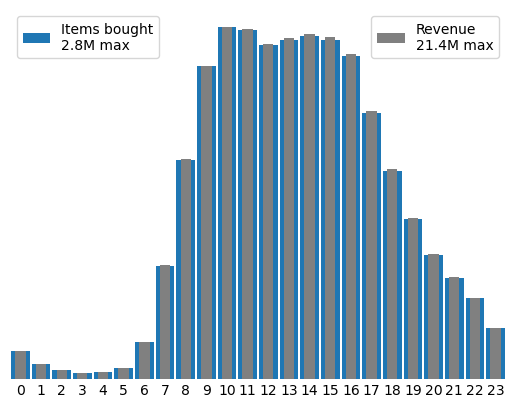

In [90]:
items_bougt = df["order_hour_of_day"].value_counts().sort_index()
max_items_mio = items_bougt.max() / 1e6
ax = items_bougt.plot.bar(width=0.9)
ax2 = ax.twinx()
revenue = df[["prices", "order_hour_of_day"]].sort_values(by="order_hour_of_day").groupby("order_hour_of_day")["prices"].sum()
max_rev_mio = revenue.max() / 1e6
revenue.plot.bar(color="gray")
da.remove_clutter(ax)
da.remove_clutter(ax2)
ax.tick_params(labelbottom=True)
ax.set_xticklabels(range(24), rotation="horizontal")

ax.legend([f"Items bought\n{max_items_mio:.1f}M max"], loc="upper left")
ax2.legend([f"Revenue\n{max_rev_mio:.1f}M max"],  loc="upper right")

## Seasonality [#](#table-of-content)

In [3]:
# # check if the weekday of datejoined matches with the order_day_of_week
# df_days = df[df["order_number"] == 1].groupby("user_id").first()[["orders_day_of_week", "date_joined"]]
# df_days["weekday_order"] = df_days["orders_day_of_week"].apply(lambda x: ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"][int(x)-1])
# df_days["weekday_joined"] = df_days["date_joined"].apply(lambda x: x.strftime("%A"))
# df_days["total_days"] = df.groupby("order_id").first().groupby("user_id")["days_since_prior_order"].sum()
# df_days

# aggregate sum for each order
df["order_price"] = df.groupby("order_id")["prices"].transform(sum)

# get data on order level / removed duplicates with .head(1)
df_order_lvl = df.sort_values(by=["user_id", "order_number"]).groupby(["user_id", "order_number"]).head(1)  # .head(1) is faster than .first()

# from date_joined, get weekday index according to the data set, i.e. Saturday=1
# x.weekday() produces values from 0 (Monday) to 6 (Sunday)
# the output is used as index for [3, 4, 5, 6, 7, 1, 2], which converts it to the indices used in the data set
df_order_lvl["weekday_joined"] = df_order_lvl["date_joined"].apply(lambda x: [3, 4, 5, 6, 7, 1, 2][x.weekday()])

# delay = how many days from the date_joined weekday to the weekday of the first order
df_order_lvl["delay"] = df_order_lvl["orders_day_of_week"] - df_order_lvl["weekday_joined"]
# correct negative values
df_order_lvl.loc[df_order_lvl["delay"]<0, "delay"] = df_order_lvl["delay"] + 7
df_order_lvl["days_since_prior_order"] = df_order_lvl["delay"]

# init order_day
order_day = df_order_lvl["date_joined"].to_list()
for i in range(len(df_order_lvl)):
    order_day[i] = \
        order_day[i] \
        + timedelta(df_order_lvl["delay"].iloc[i]) \
        + timedelta(hours=df_order_lvl["order_hour_of_day"].iloc[i]) \
        if df_order_lvl["order_number"].iloc[i] == 1 \
        else order_day[i - 1] \
             + timedelta(df_order_lvl["days_since_prior_order"].iloc[i]) \
             + timedelta(hours=df_order_lvl["order_hour_of_day"].iloc[i]) \
             - timedelta(hours=df_order_lvl["order_hour_of_day"].iloc[i-1])

df_order_lvl["order_date"] = order_day


In [4]:

df_order_lvl2 = df_order_lvl.set_index("order_date")
df_days = df_order_lvl2["order_price"].resample("D").sum()
df_mon = df_days.resample("M").sum()
df_year = df_days.resample("Y").sum()

Text(0.5, 1.0, 'Revenue per Day')

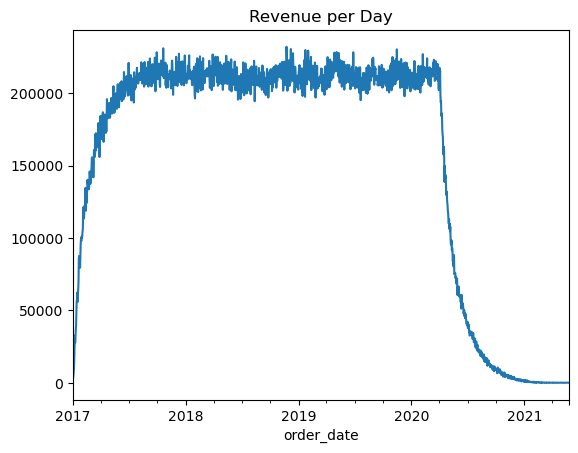

In [5]:
df_days.plot()
plt.title("Revenue per Day")

Text(0.5, 1.0, 'Revenue per Day')

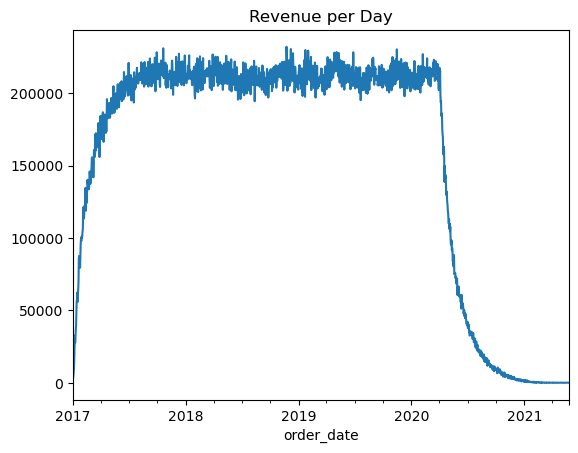

In [6]:
df_days.plot()
plt.title("Revenue per Day")

## Price Ranges [#](#table-of-content)

In [7]:
df_prods = df[["product_name", "aisle", "department", "department_category", "prices"]].groupby("product_name").head(1)

In [8]:
df_prods.shape

(49659, 5)

In [9]:
df_prods.to_csv(prepared_data_folder / "final_prods2.csv")

In [10]:

# Create a list of colors from the colormap
#colors = [cm.tab20c(i) for i in [11, 10, 8]]

# Set the default color cycle
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)


In [11]:
df_prods.loc[df_prods["prices"]<=7, "price_tag"] = "Low Price"
df_prods.loc[(7<df_prods["prices"]) & (df_prods["prices"]<=15), "price_tag"] = "Mid Price"
df_prods.loc[15<df_prods["prices"], "price_tag"] = "High Price"

# revenue
df2 = df[["product_name", "prices"]].merge(df_prods[["price_tag", "product_name"]], on="product_name")
prod_revenue = df2.groupby("price_tag")["prices"].sum()

# product count
prod_counts = df_prods.groupby("price_tag")["product_name"].count()

In [12]:
prod_counts

price_tag
High Price      545
Low Price     24746
Mid Price     24368
Name: product_name, dtype: int64

In [13]:
prod_counts.sum()

49659

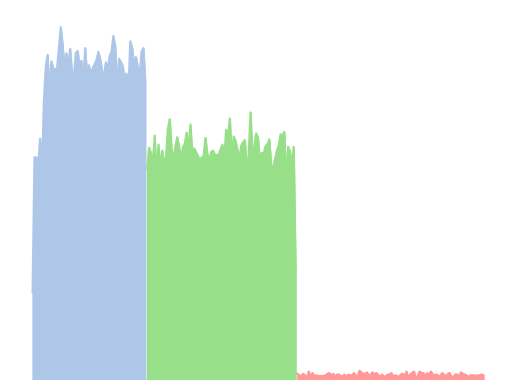

In [14]:
ax = df_prods[df_prods["prices"]<=7]["prices"].value_counts().sort_index().plot.area(color=cm.tab20(1))
df_prods[(7<df_prods["prices"]) & (df_prods["prices"]<=15)]["prices"].value_counts().sort_index().plot.area(color=cm.tab20(5))
df_prods[15<df_prods["prices"]]["prices"].value_counts().sort_index().plot.area(color=cm.tab20(7))

da.remove_clutter(ax)
ax.tick_params(labelbottom=False)


## Departments [#](#table-of-content)

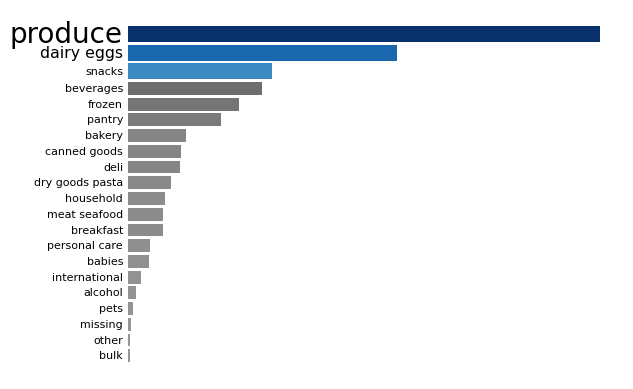

In [15]:
# Get a monochromatic color map
cmap_blue = cm.Blues
cmap_gray = cm.Greys

department_counts = df["department"].value_counts().sort_values()
num_dep = len(department_counts)

# Create a Normalize object to map values to the 0-1 range
norm = mcolors.Normalize(vmin=-department_counts.max(), 
                         vmax=department_counts.max())

# Create a color map based on the normalized values
colors = [cmap_gray(norm(value)) if i < num_dep-3 
          else cmap_blue(norm(value)) 
          for i, value in enumerate(department_counts)]

# Create a figure and axes
fig, ax = plt.subplots()

# Initialize the y position and the list of tick positions
y = 0
ticks = []

# Draw each bar separately with the specified colors and widths
for i, (value, color) in enumerate(zip(department_counts, colors)):
    width = .9 if i < num_dep-3 else 1.1
    ax.barh(y + width / 2, value, color=color, height=width)  # draw the bar with its center at y
    ticks.append(y + width / 2)  # add the center of the bar to the list of tick positions
    y += 1.1 if i < num_dep-3 else 1.3  # adjust the y position for the next bar

def format_millions(val):
    return f'{val / 1_000_000:.2f} M'

# Create y-ticks and labels
ax.set_yticks(ticks)
ax.set_yticklabels(department_counts.index, verticalalignment='center')

# Adjust font size for each tick label
for i, tick in enumerate(ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(max(department_counts.iloc[i] / department_counts.max() * 20, 8))

da.remove_clutter()
ax.tick_params(labelleft=True, labelbottom=False)



In [16]:
department_counts

bulk                 34573
other                36291
missing              69145
pets                 97716
alcohol             153696
international       269253
babies              423802
personal care       447572
breakfast           703033
meat seafood        708927
household           738666
dry goods pasta     866627
deli               1051249
canned goods       1068058
bakery             1172428
pantry             1875369
frozen             2234743
beverages          2688123
snacks             2887550
dairy eggs         5393620
produce            9479291
Name: department, dtype: int64

In [17]:
df_w_dates = df.merge(df_order_lvl[["order_id", "order_date"]], on="order_id")

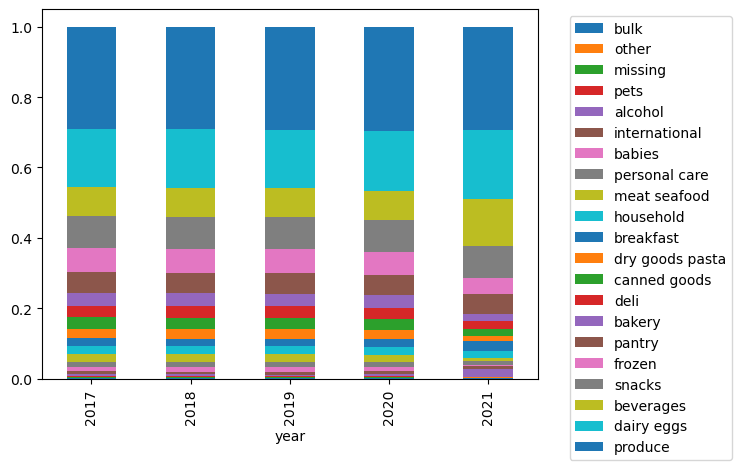

In [18]:
import matplotlib.pyplot as plt

# Extract the year from 'order_date'
df_w_dates['year'] = df_w_dates['order_date'].dt.year

# Count the number of each department per year
counts = df_w_dates.groupby(['year', 'department']).size().unstack(fill_value=0)

# Calculate the percentage of each department within each year
percentages = counts.divide(counts.sum(axis=1), axis=0)

# Sort the departments based on the percentage within each year
percentages = percentages[percentages.sum().sort_values(ascending=True).index]

# Plot the data as a 100% stacked bar chart
percentages.plot(kind='bar', stacked=True)

# Optional: Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


same behavior throughout the years

## Loyalty [#](#table-of-content)

Tenure

In [19]:
loyalty_order = ["Loyal customer", "Regular customer", "New customer"]
loyalty_color = [cm.Blues(0.99), cm.Blues(0.5), cm.Blues(0.3)]

<AxesSubplot:>

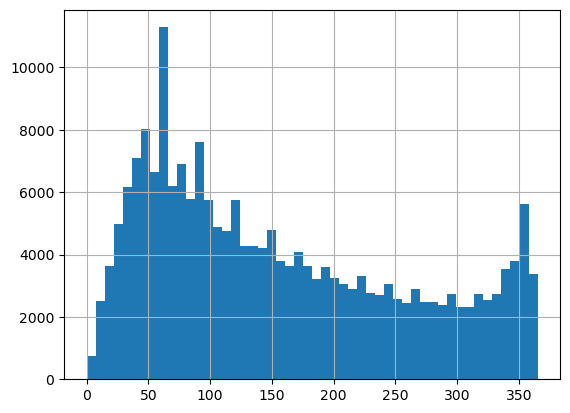

In [20]:
df_days = df[df["order_number"] == 1].groupby("user_id").first()[["orders_day_of_week", "date_joined", "loyalty_flag"]]
df_days["total_days"] = df.groupby("order_id").first().groupby("user_id")["days_since_prior_order"].sum()
df_days["total_days"].hist(bins=50)

In [21]:
df_days.shape

(206198, 4)

In [22]:
# Filter the data by each category
loyal_customer = df_days[df_days["loyalty_flag"] == "Loyal customer"]["total_days"]
regular_customer = df_days[df_days["loyalty_flag"] == "Regular customer"]["total_days"]
new_customer = df_days[df_days["loyalty_flag"] == "New customer"]["total_days"]


In [23]:
print(new_customer.shape)
print(regular_customer.shape)
print(loyal_customer.shape)

(112323,)
(76859,)
(17016,)


([<matplotlib.axis.XTick at 0x140a65e9af0>,
 [])

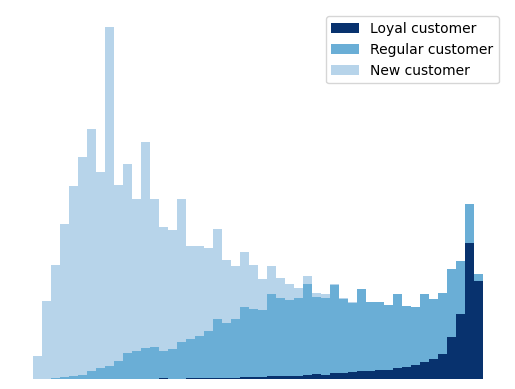

In [24]:

# Plot stacked histogram
plt.hist([loyal_customer, regular_customer, new_customer], stacked=True, label=["Loyal customer", "Regular customer", "New customer"], color=[cm.Blues(0.99), cm.Blues(0.5), cm.Blues(0.3)], bins=50);
plt.legend()
da.remove_clutter()

plt.xticks([0, 365], ["0", "365 days"])

<AxesSubplot:xlabel='loyalty_flag'>

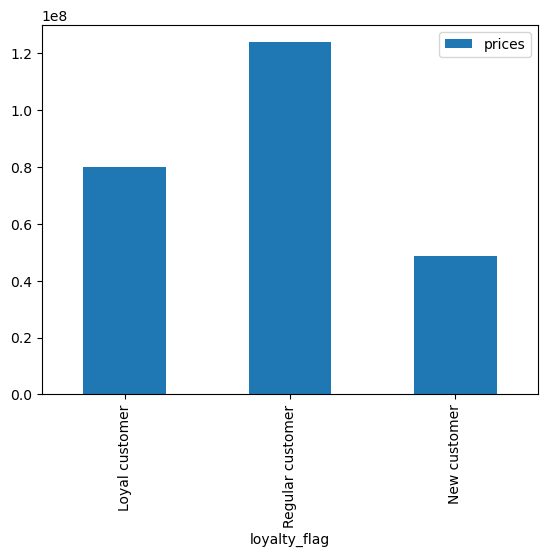

In [25]:
df[["loyalty_flag", "prices"]].groupby("loyalty_flag").sum().T[["Loyal customer", "Regular customer", "New customer"]].T.plot.bar()

<AxesSubplot:>

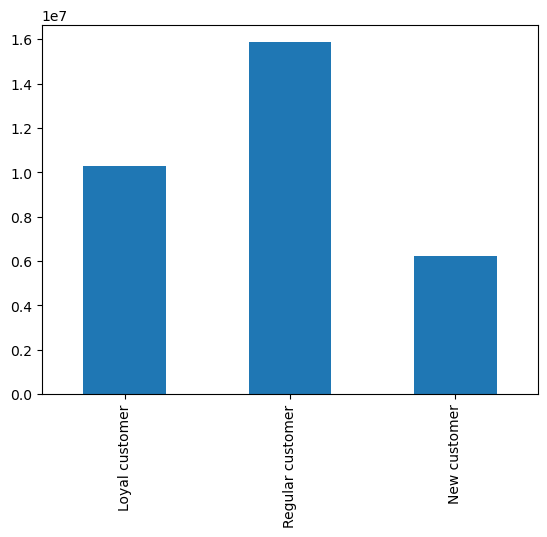

In [26]:
df["loyalty_flag"].value_counts()[["Loyal customer", "Regular customer", "New customer"]].plot.bar()

<AxesSubplot:>

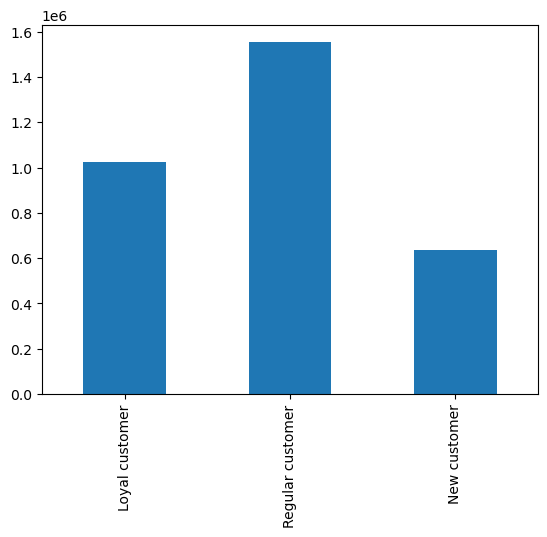

In [27]:
df.groupby("order_id").first()["loyalty_flag"].value_counts()[["Loyal customer", "Regular customer", "New customer"]].plot.bar()

User Count

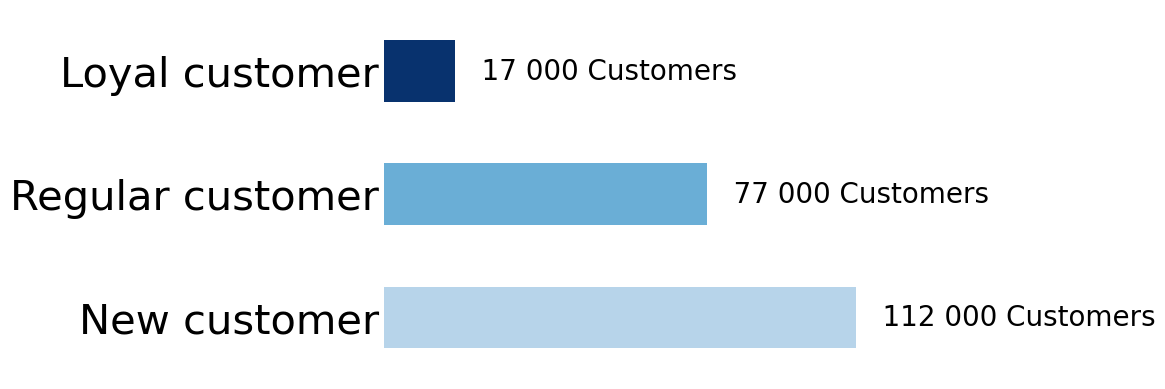

In [28]:
df.groupby("user_id").first()["loyalty_flag"].value_counts()[["New customer", "Regular customer", "Loyal customer"]].plot.barh(color=[cm.Blues(0.3), cm.Blues(0.5), cm.Blues(0.99)])
da.remove_clutter()
plt.tick_params(labelbottom=False, labelleft=True, labelsize=30)
for container in plt.gca().containers:
    plt.bar_label(container, labels=[f"   {bar.get_width()/1_000:.0f} 000 Customers" for bar in container], fontsize=20)

Ordering habits

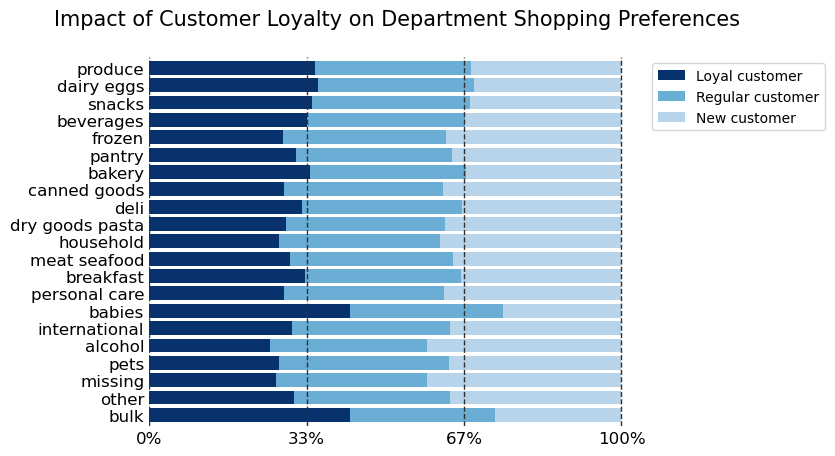

In [29]:
da.bar100(data=df, x="loyalty_flag", y="department", 
          xorder=loyalty_order, 
          title="Impact of Customer Loyalty on Department Shopping Preferences\n",
          bar_dict = dict(color=loyalty_color))

## Region [#](#table-of-content)

In [30]:
df.columns

Index(['add_to_cart_order', 'age', 'aisle', 'aisle_id', 'avg_usr_prices',
       'busiest_day', 'busiest_period_of_day', 'date_joined',
       'days_since_prior_order', 'department', 'department_category',
       'department_id', 'division', 'fam_status', 'gender', 'income',
       'loyalty_flag', 'max_order', 'median_days_since_prior_order',
       'n_dependants', 'order_freq_flag', 'order_hour_of_day', 'order_id',
       'order_number', 'orders_day_of_week', 'price_label', 'prices',
       'product_id', 'product_name', 'region', 'reordered', 'spending_flag',
       'state', 'state_code', 'user_id', 'age_profile', 'income_profile',
       'fam_profile', 'party_product', 'order_price'],
      dtype='object')

In [31]:
df["region"].value_counts()

South        10790096
West          8291679
Midwest       7596065
Northeast     5721892
Name: region, dtype: int64

In [32]:
df.groupby("region").count()

,add_to_cart_order,age,aisle,aisle_id,avg_usr_prices,busiest_day,busiest_period_of_day,date_joined,days_since_prior_order,department,...,reordered,spending_flag,state,state_code,user_id,age_profile,income_profile,fam_profile,party_product,order_price
region,,,,,,,,,,,,,,,,,,,,,
Midwest,7596065,7596065,7596065,7596065,7596065,7596065,7596065,7596065,7596065,7596065,...,7596065,7596065,7596065,7596065,7596065,7596065,7515864,7596065,7596065,7596065
Northeast,5721892,5721892,5721892,5721892,5721892,5721892,5721892,5721892,5721892,5721892,...,5721892,5721892,5721892,5721892,5721892,5721892,5669907,5721892,5721892,5721892
South,10790096,10790096,10790096,10790096,10790096,10790096,10790096,10790096,10790096,10790096,...,10790096,10790096,10790096,10790096,10790096,10790096,10684201,10790096,10790096,10790096
West,8291679,8291679,8291679,8291679,8291679,8291679,8291679,8291679,8291679,8291679,...,8291679,8291679,8291679,8291679,8291679,8291679,8212626,8291679,8291679,8291679


In [33]:
region_color_scheme = {
    "Midwest": "#6CB875",    # Green with reduced luminance
    "Northeast": "#6582A3",  # Blue with reduced luminance
    "South": "#C85E5E",      # Red with reduced luminance
    "West": "#D9A453"        # Orange with reduced luminance
}

Text(0.5, 1.0, 'Impact of Region on Department Shopping Preferences\n')

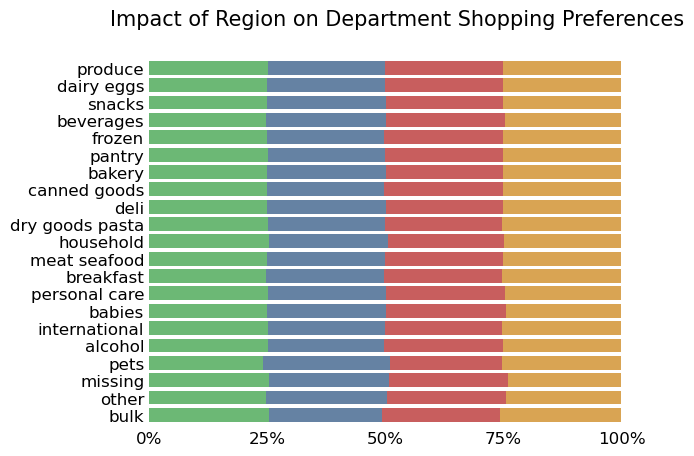

In [34]:
cross_tab = pd.crosstab(df["department"], df["region"])[region_color_scheme.keys()]
cross_tab = cross_tab.loc[cross_tab.sum(axis=1).sort_values(ascending=True).index]  # sort by sum of all
cross_tab = cross_tab.div(cross_tab.sum(axis=0), axis=1) # normalize by region
cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0)*100 # normalize by department
cross_tab.plot.barh(stacked=True, width=0.8, legend=None, color=region_color_scheme.values())
#plt.legend(loc="center").set_title(None)
da.remove_clutter()
plt.tick_params(labelleft=True, labelbottom=True, labelsize=12)
ticks = np.linspace(0,100,5)
labels = [f"{l:.0f}%" for l in ticks]
plt.xticks(ticks, labels);
plt.title("Impact of Region on Department Shopping Preferences\n", fontsize=15)

## Age Group and Fam Status [#](#table-of-content)

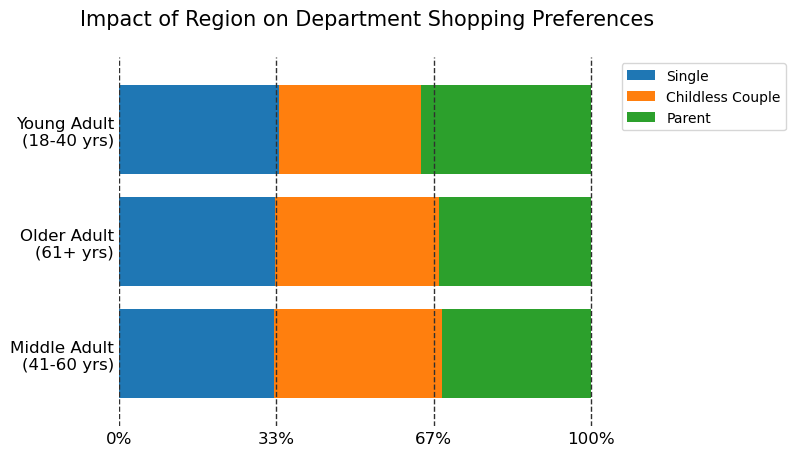

In [35]:
da.bar100(data=df, x="fam_profile", y="age_profile", 
          xorder=["Single", "Childless", "Parent"], 
          yorder=["Young Adult", "Middle Adult", "Older Adult"], 
          title="Impact of Region on Department Shopping Preferences\n")

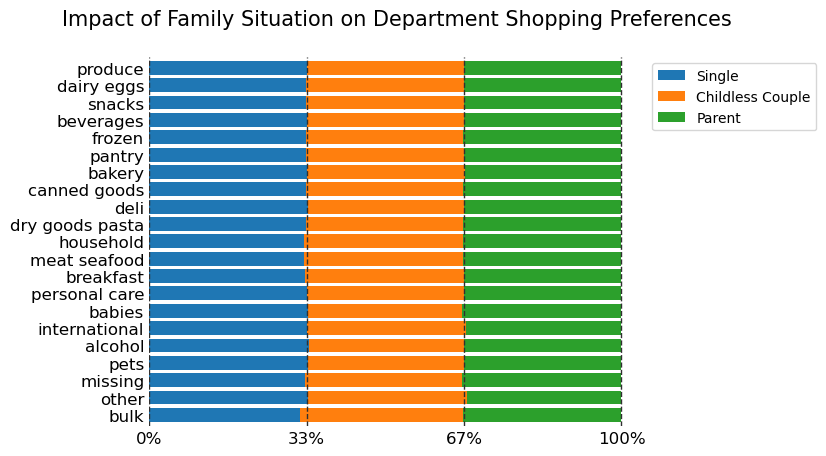

In [36]:
title = "Impact of Family Situation on Department Shopping Preferences\n"
da.bar100(data=df, x="fam_profile", y="department", xorder=["Single", "Childless", "Parent"], title=title)

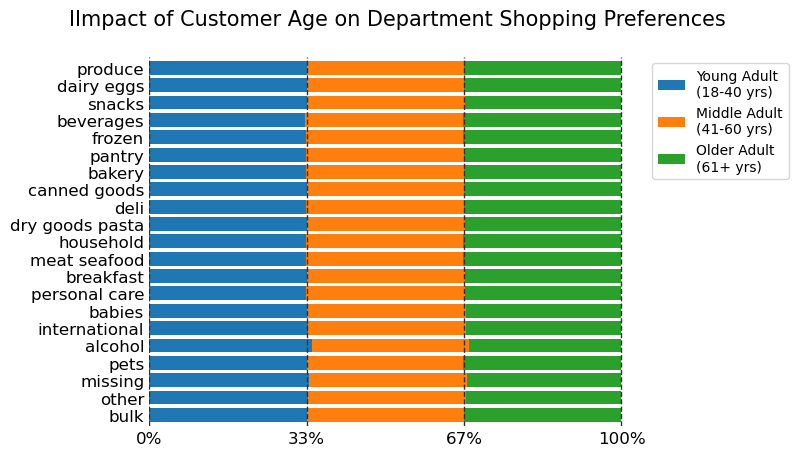

In [37]:
da.bar100(data=df, x="age_profile", y="department", 
          xorder=["Young Adult", "Middle Adult", "Older Adult"], 
          title="IImpact of Customer Age on Department Shopping Preferences\n")

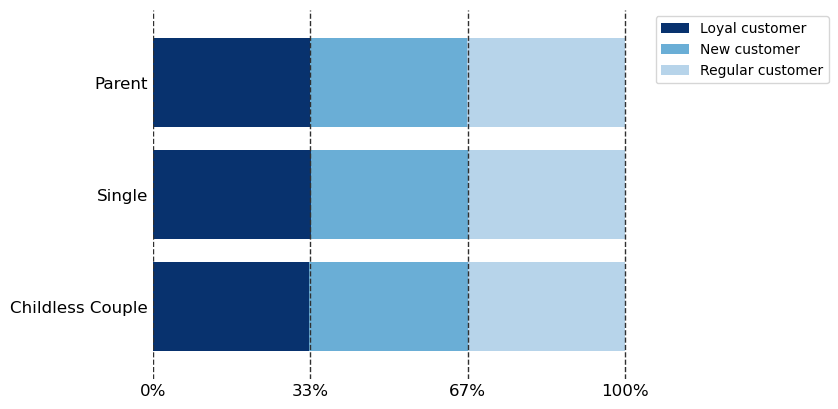

In [38]:
da.bar100(data=df, x="loyalty_flag", y="fam_profile",
          bar_dict = dict(color=loyalty_color))